# Predicting Bounding Boxes

Welcome to Course 3, Week 1 Programming Assignment! 

In this week's assignment, you'll build a model to predict bounding boxes around images.  
- You will use transfer learning on any of the pre-trained models available in Keras. 
- You'll be using the [Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html) dataset. 


### How to submit your work
Notice that there is not a "submit assignment" button in this notebook.  

To check your work and get graded on your work, you'll train the model, save it and then upload the model to Coursera for grading.

- [Initial steps](#0)
  - [0.1 Set up your Colab](#0-1)
  - [0.2 Set up the data location](#0-2)
  - [0.3 Choose the GPU Runtime](#0-3)
  - [0.4 Mount your drive](#0-4)
  - [0.5 Imports](#0-5)
- [1. Visualization Utilities](#1)
  - [1.1 Bounding Boxes Utilities](#1-1)
  - [1.2 Data and Predictions Utilities](#1-2)
- [2. Preprocessing and Loading the Dataset](#2)
  - [2.1 Preprocessing Utilities](#2-1)
  - [2.2 Visualize the prepared Data](#2-2)
  - [2.3 Loading the Dataset](#2-3)
- [3. Define the Network](#3)
  - [Exercise 1](#ex-01)
  - [Exercise 2](#ex-02)
  - [Exercise 3](#ex-03)
  - [Exercise 4](#ex-04)
  - [Exercise 5](#ex-05)
- [4. Training the Model](#4)
  - [Prepare to train the model](#4.1)
  - [Exercise 6](#ex-06)
  - [Fit the model to the data](#4.2)
  - [Exercise 7](#ex-07)
- [5. Validate the Model](#5)
  - [5.1 Loss](#5-1)
  - [5.2 Save your Model](#5-2)
  - [5.3 Plot the Loss Function](#5-3)  
  - [5.4 Evaluate performance using IoU](#5-4)
- [6. Visualize Predictions](#6)
- [7. Upload your model for grading](#7)


<a name="0"></a>
## 0. Initial steps

<a name="0-1"></a>
## 0.1 Set up your Colab

- As you cannot save the changes you make to this colab, you have to make a copy of this notebook in your own drive and run that. 
- You can do so by going to `File -> Save a copy in Drive`. 
- Close this colab and open the copy which you have made in your own drive. Then continue to the next step to set up the data location.

<a name="0-2"></a>
## Set up the data location
A copy of the dataset that you'll be using is stored in a publicly viewable Google Drive folder.  You'll want to add a shortcut to it to your own Google Drive.
- Go to this google drive folder named [TF3 C3 W1 Data](https://drive.google.com/drive/folders/1xgqUw9uWzL5Kh88iPdX1TBQgnkc-wVKd?usp=sharing)
- Next to the folder name "TF3 C3 W1 Data", hover your mouse over the triangle to reveal the drop down menu. 
- Use the drop down menu to select `"Add shortcut to Drive"`  A pop-up menu will open up. 
- In the pop-up menu, "My Drive" is selected by default.  Click the `ADD SHORTCUT` button. This should add a shortcut to the folder `TF3 C3 W1 Data` within your own google drive at the location `content/drive`.
- To verify, go to the left-side menu and click on "My Drive".  Scroll through your files to look for the shortcut TF3 C3 W1 Data.  

Please make sure this happens, as you'll be reading the data for this notebook from this folder.

<a name="0-3"></a>
## 0.3 Choose the GPU Runtime
- Make sure your runtime is **GPU** (_not_ CPU or TPU). And if it is an option, make sure you are using _Python 3_. You can select these settings by going to `Runtime -> Change runtime type -> Select the above mentioned settings and then press SAVE`

<a name="0-4"></a>
## 0.4 Mount your drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.
- Run the code cell below.  A web link will appear below the cell.
- Please click on the web link, which will open a new tab in your browser, which asks you to choose your google account.
- Choose your google account to login.
- The page will display "Google Drive File Stream wants to access your Google Account".  Please click "Allow".
- The page will now show a code (a line of text).  Please copy the code and return to this Colab.
- Paste the code the textbox that is labeled "Enter your authorization code:" and hit `<Enter>`
- The text will now say "Mounted at /content/drive/"

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<a name="0-5"></a>
## 0.5 Imports

In [2]:
# If you get a checksum error with the dataset, you'll need this
!pip install tfds-nightly==4.0.1.dev202010100107

     |████████████████████████████████| 3.6MB 9.1MB/s 


In [3]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

Store the path to the data.
- Remember to follow the steps to `set up the data location` (above) so that you'll have a shortcut to the data in your Google Drive.

In [4]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

<a name="1"></a>
## 1. Visualization Utilities


<a name="1-1"></a>
### 1.1 Bounding Boxes Utilities

We have provided you with some functions which you will use to draw bounding boxes around the birds in the `image`.

- `draw_bounding_box_on_image`: Draws a single bounding box on an image.
- `draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.
- `draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

<a name="1-2"></a>
### 1.2 Data and Predictions Utilities

We've given you some helper functions and code that are used to visualize the data and the model's predictions.

- `display_digits_with_boxes`: This displays a row of "digit" images along with the model's predictions for each image.
- `plot_metrics`: This plots a given metric (like loss) as it changes over multiple epochs of training.  

In [6]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of images with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

<a name="2"></a>
## 2. Preprocess and Load the Dataset

<a name="2-1"></a>
### 2.1 Preprocessing Utilities

We have given you some helper functions to pre-process the image data.

#### read_image_tfds
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [7]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

#### read_image_with_shape
This is very similar to `read_image_tfds` except it also keeps a copy of the original image (before pre-processing) and returns this as well.
- Makes a copy of the original image.
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [8]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

#### read_image_tfds_with_original_bbox

- This function reads `image` from `data`
- It also denormalizes the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)

In [9]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

#### dataset_to_numpy_util
This function converts a `dataset` into numpy arrays of images and boxes.
- This will be used when visualizing the images and their bounding boxes

In [10]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

#### dataset_to_numpy_with_original_bboxes_util

- This function converts a `dataset` into numpy arrays of 
  - original images
  - resized and normalized images
  - bounding boxes
- This will be used for plotting the original images with true and predicted bounding boxes.

In [11]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

<a name="2-2"></a>
### 2.2 Visualize the images and their bounding box labels
Now you'll take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

Visualize the **training** images and their bounding box labels

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


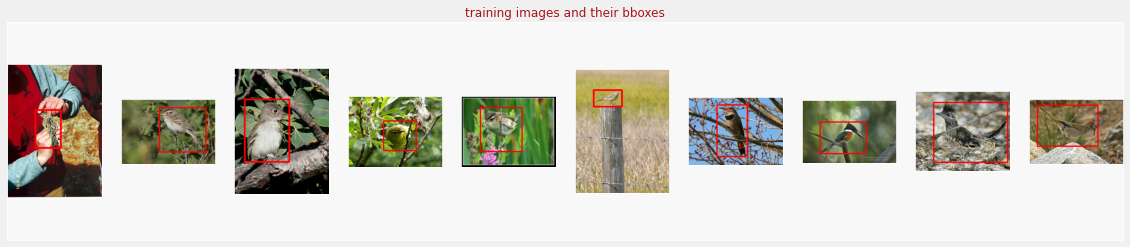

In [12]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

Visualize the **validation** images and their bounding boxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


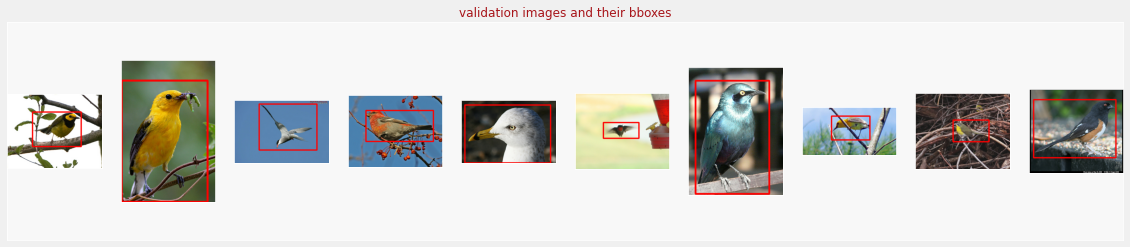

In [13]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

<a name="2-3"></a>
### 2.3 Load and prepare the datasets for the model

These next two functions read and prepare the datasets that you'll feed to the model.
- They use `read_image_tfds` to resize, and normalize each image and its bounding box label.
- They performs shuffling and batching.
- You'll use these functions to create `training_dataset` and `validation_dataset`, which you will give to the model that you're about to build.

In [14]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

<a name="3"></a>
## 3. Define the Network

Bounding box prediction is treated as a "regression" task, in that you want the model to output numerical values.

- You will be performing transfer learning with **MobileNet V2**.  The model architecture is available in TensorFlow Keras.
- You'll also use pretrained `'imagenet'` weights as a starting point for further training.  These weights are also readily available 
- You will choose to retrain all layers of **MobileNet V2** along with the final classification layers.

**Note:** For the following exercises, please use the TensorFlow Keras Functional API (as opposed to the Sequential API).

<a name='ex-01'></a>
### Exercise 1

Please build a feature extractor using MobileNetV2.

- First, create an instance of the mobilenet version 2 model
  - Please check out the documentation for [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)
  - Set the following parameters:
    - input_shape: (height, width, channel): input images have height and width of 224 by 224, and have red, green and blue channels.
    - include_top: you do not want to keep the "top" fully connected layer, since you will customize your model for the current task.
    - weights: Use the pre-trained 'imagenet' weights.
  
- Next, make the feature extractor for your specific inputs by passing the `inputs` into your mobilenet model.
    - For example, if you created a model object called `some_model` and have inputs stored in `x`, you'd invoke the model and pass in your inputs like this: `some_model(x)` to get the feature extractor for your given inputs `x`.

**Note**: please use mobilenet_v2 and not mobile_net or mobile_net_v3

In [15]:
def feature_extractor(inputs):
    ### YOUR CODE HERE ###
    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
    

    # pass the inputs into this model object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    

    ### END CODE HERE ###
        
    # return the feature_extractor
    return feature_extractor

<a name='ex-02'></a>
### Exercise 2

Next, you'll define the dense layers to be used by your model.

You'll be using the following layers
- [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D): pools the `features`.
- [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): flattens the pooled layer.
- [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Add two dense layers:
    - A dense layer with 1024 neurons and a relu activation.
    - A dense layer following that with 512 neurons and a relu activation.
    
**Note**: Remember, please build the model using the Functional API syntax (as opposed to the Sequential API).

In [16]:
def dense_layers(features):
    ### YOUR CODE HERE ###

    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    
    ### END CODE HERE ###
    
    return x

<a name='ex-03'></a>
### Exercise 3


Now you'll define a layer that outputs the bounding box predictions. 
- You'll use a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer.
- Remember that you have _4 units_ in the output layer, corresponding to (xmin, ymin, xmax, ymax).
- The prediction layer follows the previous dense layer, which is passed into this function as the variable `x`.
- For grading purposes, please set the `name` parameter of this Dense layer to be `bounding_box'

In [17]:
def bounding_box_regression(x):
    ### YOUR CODE HERE ###
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = 'bounding_box')(x)

    ### END CODE HERE ###
        

    return bounding_box_regression_output

<a name='ex-04'></a>
### Exercise 4

Now, you'll use those functions that you have just defined above to construct the model.
- feature_extractor(inputs)
- dense_layers(features)
- bounding_box_regression(x)

Then you'll define the model object using [Model](https://www.tensorflow.org/s/results?q=Model).  Set the two parameters:
- inputs
- outputs

In [18]:
def final_model(inputs):
    ### YOUR CODE HERE ###

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs, bounding_box_output)

    ### END CODE HERE ###
    
    
    return model

<a name='ex-05'></a>
### Exercise 5

Define the input layer, define the model, and then compile the model. 
- inputs: define an [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layer
  - Set the `shape` parameter.  Check your definition of `feature_extractor` to see the expected dimensions of the input image.
- model: use the `final_model` function that you just defined to create the model.
- compile the model: Check the [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) documentation for how to compile the model.
  - Set the `optimizer` parameter to Stochastic Gradient Descent using [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)
    - When using SGD, set the `momentum` to 0.9 and keep the default learning rate.
  - Set the loss function of SGD to mean squared error (see the SGD documentation for an example of how to choose mean squared error loss).

In [19]:
def define_and_compile_model():
  
    ### YOUR CODE HERE ###

    # define the input layer
    inputs = tf.keras.layers.Input(shape = (224, 224, 3))
    
    # create the model
    model = final_model(inputs)
    
    # compile your model
    model.compile(optimizer = tf.keras.optimizers.SGD(momentum = 0.9), loss = 'mse')

    ### END CODE HERE ###
    

    return model

Run the cell below to define your model and print the model summary.

In [20]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
________________________________________________________________

Your expected model summary:

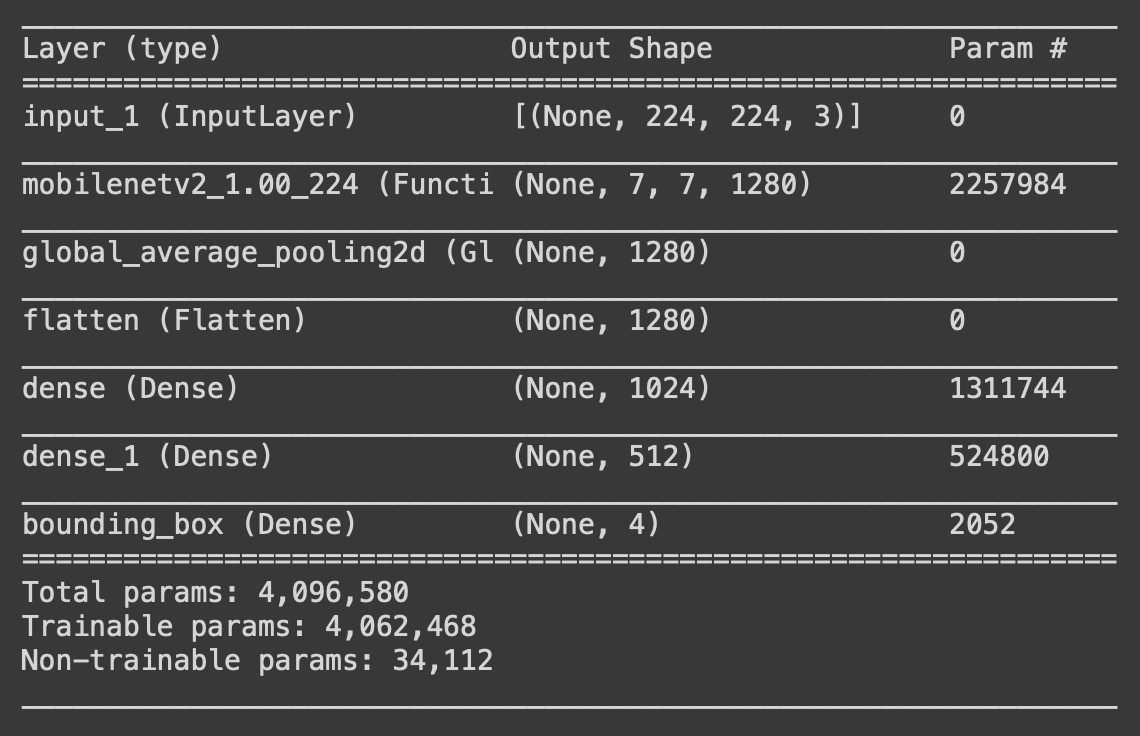

<a name='4'></a>
## Train the Model

<a name='4.1'></a>
### 4.1 Prepare to Train the Model

You'll fit the model here, but first you'll set some of the parameters that go into fitting the model.

- EPOCHS: You'll train the model for 50 epochs
- BATCH_SIZE: Set the `BATCH_SIZE` to an appropriate value. You can look at the ungraded labs from this week for some examples.
- length_of_training_dataset: this is the number of training examples.  You can find this value by getting the length of `visualization_training_dataset`.
  - Note: You won't be able to get the length of the object `training_dataset`. (You'll get an error message).
- length_of_validation_dataset: this is the number of validation examples.  You can find this value by getting the length of `visualization_validation_dataset`.
  - Note: You won't be able to get the length of the object `validation_dataset`.
- steps_per_epoch: This is the number of steps it will take to process all of the training data.  
  - If the number of training examples is not evenly divisible by the batch size, there will be one last batch that is not the full batch size.
  - Try to calculate the number steps it would take to train all the full batches plus one more batch containing the remaining training examples. There are a couples ways you can calculate this.
    - You can use regular division `/` and import `math` to use `math.ceil()` [Python math module docs](https://docs.python.org/3/library/math.html)
    - Alternatively, you can use `//` for integer division, `%` to check for a remainder after integer division, and an `if` statement.
  
- validation_steps: This is the number of steps it will take to process all of the validation data.  You can use similar calculations that you did for the step_per_epoch, but for the validation dataset.

<a name='ex-06'></a>
### Exercise 6

In [21]:
# You'll train 50 epochs
EPOCHS = 50

### START CODE HERE ###

# Choose a batch size
BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)
# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = length_of_training_dataset // BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    steps_per_epoch += 1

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
### END CODE HERE

<a name='4.2'></a>
### 4.2 Fit the model to the data


Check out the parameters that you can set to fit the [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).  Please set the following parameters.
- x: this can be a tuple of both the features and labels, as is the case here when using a tf.Data dataset.
  - Please use the variable returned from `get_training_dataset()`.
  - Note, don't set the `y` parameter when the `x` is already set to both the features and labels.
- steps_per_epoch: the number of steps to train in order to train on all examples in the training dataset.
- validation_data: this is a tuple of both the features and labels of the validation set.
  - Please use the variable returned from `get_validation_dataset()`
- validation_steps: teh number of steps to go through the validation set, batch by batch.
- epochs: the number of epochs.

If all goes well your model's training will start.

<a name='ex-07'></a>
### Exercise 7

In [23]:
### YOUR CODE HERE ####

# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(training_dataset, steps_per_epoch = steps_per_epoch, epochs = EPOCHS, validation_data = validation_dataset, validation_steps = validation_steps)

### END CODE HERE ###

Epoch 1/50
47/47 [==============================] - 37s 583ms/step - loss: 0.2805 - val_loss: 0.3604
Epoch 2/50
47/47 [==============================] - 26s 569ms/step - loss: 0.0190 - val_loss: 0.2938
Epoch 3/50
47/47 [==============================] - 26s 560ms/step - loss: 0.0135 - val_loss: 0.2245
Epoch 4/50
47/47 [==============================] - 27s 572ms/step - loss: 0.0104 - val_loss: 0.1871
Epoch 5/50
47/47 [==============================] - 26s 567ms/step - loss: 0.0087 - val_loss: 0.1534
Epoch 6/50
47/47 [==============================] - 26s 560ms/step - loss: 0.0078 - val_loss: 0.1258
Epoch 7/50
47/47 [==============================] - 27s 571ms/step - loss: 0.0064 - val_loss: 0.1055
Epoch 8/50
47/47 [==============================] - 27s 574ms/step - loss: 0.0057 - val_loss: 0.0956
Epoch 9/50
47/47 [==============================] - 27s 578ms/step - loss: 0.0051 - val_loss: 0.0820
Epoch 10/50
47/47 [==============================] - 26s 567ms/step - loss: 0.0047 - val_lo

<a name='5'></a>
## 5. Validate the Model

<a name='5-1'></a>
### 5.1 Loss

You can now evaluate your trained model's performance by checking its loss value on the validation set.

In [24]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 [==============================] - 11s 219ms/step - loss: 0.0171
Loss:  0.01705082319676876


<a name='5-2'></a>
### 5.2 Save your Model for Grading

When you have trained your model and are satisfied with your validation loss, please you save your model so that you can upload it to the Coursera classroom for grading.

In [25]:
# Please save your model
model.save("birds.h5")

In [26]:
# And download it using this shortcut or from the "Files" panel to the left
from google.colab import files

files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a name='5-3'></a>
### 5.3 Plot Loss Function

You can also plot the loss metrics.

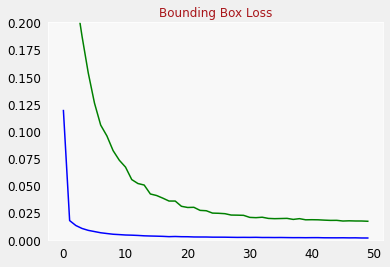

In [27]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

<a name='5-4'></a>
### 5.4 Evaluate performance using IoU

You can see how well your model predicts bounding boxes on the validation set by calculating the Intersection-over-union (IoU) score for each image.

- You'll find the IoU calculation implemented for you.
- Predict on the validation set of images.
- Apply the `intersection_over_union` on these predicted bounding boxes.

In [28]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 256
Number of predictions where iou < threshold(0.5): 244


<a name='6'></a>
## 6. Visualize Predictions

Lastly, you'll plot the predicted and ground truth bounding boxes for a random set of images and visually see how well you did!


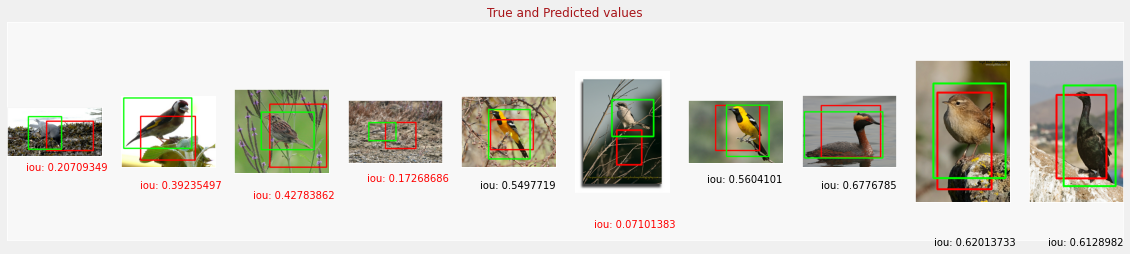

In [29]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)

<a name='7'></a>
# 7 Upload your model for grading

Please return to the Coursera classroom and find the section that allows you to upload your 'birds.h5' model for grading.  Good luck!